# Data basics

## Data processing

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/D0-processing"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\D0-processing`


### More data processing

This tutorial uses the World Resources Institute Global Power Plants Dataset to explore data pre-processing in Julia. The dataset is created from multiple sources and is under continuous update, which means that there are lots of missing data, non-standard characters, etc Hence plenty of material to work with!

More tutorials on the manipulation of DataFrames can be found here And some more information can be found on this wikipage.

> https://en.wikibooks.org/wiki/Introducing_Julia/DataFrames

In [2]:
import MLJ: schema, std, mean, median, coerce, coerce!, scitype
using DataFrames
using UrlDownload
using PyPlot

Import data

In [3]:
raw_data = urldownload("https://github.com/tlienart/DataScienceTutorialsData.jl/blob/master/data/wri_global_power_plant_db_be_022020.csv?raw=true")
data = DataFrame(raw_data);

This dataset contains information on power generation plants for a number of countries around the world. The level of disaggregation is the power plant. For each plant, there is information about its name, localisation, capacity, and many other features. The schema function enables us to get a quick overview of the variables it contains, including their machine and scentific types.

In [4]:
schema(data)

┌──────────────────────────┬────────────────────────────┬───────────────────────
│ names                    │ scitypes                   │ types                ⋯
├──────────────────────────┼────────────────────────────┼───────────────────────
│ country                  │ Textual                    │ String3              ⋯
│ country_long             │ Textual                    │ String               ⋯
│ name                     │ Textual                    │ String               ⋯
│ gppd_idnr                │ Textual                    │ String15             ⋯
│ capacity_mw              │ Continuous                 │ Float64              ⋯
│ latitude                 │ Continuous                 │ Float64              ⋯
│ longitude                │ Continuous                 │ Float64              ⋯
│ primary_fuel             │ Textual                    │ String15             ⋯
│ other_fuel1              │ Union{Missing, Textual}    │ Union{Missing, Strin ⋯
│ other_fuel2              │

We see that a small number of features have values for all plants (i.e. for each row) present in the dataset. 

However, 

- (i) several features have missing values (Union{Missing, _.type}) and 
- (ii) we are not interested in working with all of these features. 

In particular, we're not intersted in the source of the information present in the dataset nor are we interested in the generation data. 

Hence we drop all columns which contain information's source. 

We define a function ```is_active()``` that will return a ```TRUE``` boolean value if the column name does NOT (!) contain either of the strings "source" or "generation". 

_Note the conversion of column names from :Symbol to :string since the occursing function only accepts strings as arguments._

In [5]:
is_active(col) = !occursin(r"source|generation", string(col))
active_cols = [col for col in names(data) if is_active(col)]
select!(data, active_cols)

,country,country_long,name
,String3,String,String
1,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan
2,AFG,Afghanistan,Kandahar DOG
3,AFG,Afghanistan,Kandahar JOL
4,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan
5,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan
6,AFG,Afghanistan,Nangarhar (Darunta) Hydroelectric Power Plant Afghanistan
7,AFG,Afghanistan,Northwest Kabul Power Plant Afghanistan
8,AFG,Afghanistan,Pul-e-Khumri Hydroelectric Power Plant Afghanistan
9,AFG,Afghanistan,Sarobi Dam Hydroelectric Power Plant Afghanistan


We also drop a number of other unwanted columns and take a look at our "new" dataframe.

In [6]:
select!(data, Not([:wepp_id, :url, :owner]))
schema(data)

┌───────────────────────┬────────────────────────────┬──────────────────────────
│ names                 │ scitypes                   │ types                   ⋯
├───────────────────────┼────────────────────────────┼──────────────────────────
│ country               │ Textual                    │ String3                 ⋯
│ country_long          │ Textual                    │ String                  ⋯
│ name                  │ Textual                    │ String                  ⋯
│ gppd_idnr             │ Textual                    │ String15                ⋯
│ capacity_mw           │ Continuous                 │ Float64                 ⋯
│ latitude              │ Continuous                 │ Float64                 ⋯
│ longitude             │ Continuous                 │ Float64                 ⋯
│ primary_fuel          │ Textual                    │ String15                ⋯
│ other_fuel1           │ Union{Missing, Textual}    │ Union{Missing, String15 ⋯
│ other_fuel2           │ Un

The remaining variables have two different scientific types: Continuous, Textual Of which we can get an overview.

In [7]:
# The describe() function shows that there are several features with missing values.

describe(data)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,country,,AFG,,ZWE,0
2,country_long,,Afghanistan,,Zimbabwe,0
3,name,,'Muela,,\u200bVärtaverket,0
4,gppd_idnr,,ARG0000001,,WRI1075863,0
5,capacity_mw,168.993,1.0,18.3,22500.0,0
6,latitude,32.5014,-77.847,39.5835,71.292,0
7,longitude,-4.1955,-179.978,-1.2744,179.389,0
8,primary_fuel,,Biomass,,Wind,0
9,other_fuel1,,Biomass,,Wind,31680


Note: the describe() function is from the DataFrames package (and won't work with other, non DataFrames, tables) whereas the schema() is from the MLJ package.

---

Let's play around with capacity data, for which there are no missing values. We create a sub-dataframe and aggregate over certain dimensions (country and primary_fuel)

In [8]:
capacity = select(data, [:country , :primary_fuel, :capacity_mw]);
first(capacity, 5)

,country,primary_fuel,capacity_mw
,String3,String15,Float64
1,AFG,Hydro,33.0
2,AFG,Solar,10.0
3,AFG,Solar,10.0
4,AFG,Hydro,66.0
5,AFG,Hydro,100.0


This dataframe contains several subgroups (country and technology type) and it would be interesting to get data aggregates by subgroup. To obtain a ```view``` of the DataFrame by subgroup, we can use the ```groupby``` function. (See the DataFrame tutorial for an introduction to the use of ```groupby```)

In [9]:
cap_gr = groupby(capacity, [:country , :primary_fuel]);

If we want to aggregate at the country-fuel-type level and calculate summary statistics at this level, we can use the ```combine``` function on the GroupedDataFrame that we just created. This function takes the GroupedDataFrame, the symbol of the column on which to apply the measure of choice as arguments.

In [10]:
cap_mean = combine(cap_gr, :capacity_mw => mean)
cap_sum = combine(cap_gr, :capacity_mw => sum)
first(cap_sum, 3)

,country,primary_fuel,capacity_mw_sum
,String3,String15,Float64
1,AFG,Hydro,238.55
2,AFG,Solar,20.0
3,AFG,Gas,42.0


In [11]:
first(cap_mean, 3)

,country,primary_fuel,capacity_mw_mean
,String3,String15,Float64
1,AFG,Hydro,39.7583
2,AFG,Solar,10.0
3,AFG,Gas,42.0


Now let's plot some of this aggregate data for a selection of countries, by country and technology type

In [12]:
ctry_selec = r"BEL|FRA|DEU"
tech_selec = r"Solar"

cap_sum_plot = cap_sum[occursin.(ctry_selec, cap_sum.country) .& occursin.(tech_selec, cap_sum.primary_fuel), :]

,country,primary_fuel,capacity_mw_sum
,String3,String15,Float64
1,BEL,Solar,116.2
2,FRA,Solar,4910.42
3,DEU,Solar,6770.56


```julia
occursin(needle::Union{AbstractString,AbstractPattern,AbstractChar}, haystack::AbstractString)
occursin(haystack)

Determine whether the first argument is a substring of the second. If needle is a regular expression, checks whether haystack contains a match.

julia> occursin("Julia", "JuliaLang is pretty cool!")
true

julia> occursin('a', "JuliaLang is pretty cool!")
true

julia> occursin(r"a.a", "aba")
true

julia> occursin(r"a.a", "abba")
false
```

Note the ```.``` for element-wise comparison Before plotting, we can also sort values by decreasing order using ```sort!()```.

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


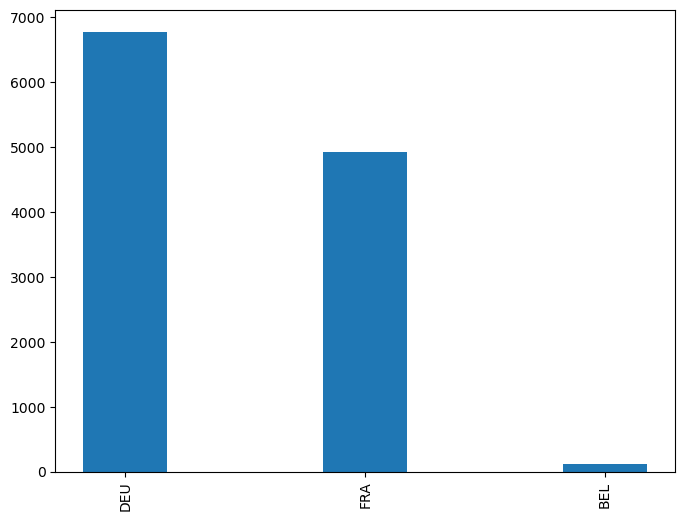

In [13]:
sort!(cap_sum_plot, :capacity_mw_sum, rev = true)

figure(figsize = (8, 6))

plt.bar(cap_sum_plot.country, cap_sum_plot.capacity_mw_sum, width = 0.35)
plt.xticks(rotation = 90)
savefig("./plots/1.5.1.png")

---
Now that we have the total capacity by country and technology type, let's use it to calculate the share of each technology in total capacity. To that end we first create a dataframe containing the country-level total capacity, using the same steps as above.

In [14]:
cap_sum_ctry_gd = groupby(capacity, [:country]);
cap_sum_ctry = combine(cap_sum_ctry_gd, :capacity_mw => sum);

The we join this dataframe with the disaggregated one; which requires that we convert the two GroupedDataFrame into DataFrames.

In [15]:
cap_sum = DataFrame(cap_sum);
cap_sum_ctry = DataFrame(cap_sum_ctry);
cap_share = leftjoin(cap_sum, cap_sum_ctry, on = :country, makeunique = true)
cap_share.capacity_mw_share = cap_share.capacity_mw_sum ./ cap_share.capacity_mw_sum_1;

Let's visualise our dataframe again, which now includes the ```capacity_mw_share``` column.

---
Now let's analyse features which exhibit some missing values. Suppose we want to calculate the age of each plant (rounded to full years). We face two issues. First, the commissioning_year is not reported for all plants. We need to gauge the representativity of the plants for which it is available with regard to the full dataset. One way to count the missing values is

In [16]:
nMissings = length(findall(x -> ismissing(x), data.commissioning_year))

17340

This represents about half of our observations

In [17]:
nMissings_share = nMissings/size(data)[1]

0.515411824153613

Second, the commissioning year is not reported as an integer. Fractions of years are reported too. As a result, the machine type of ```data.commissioning_year``` is Float64.

In [18]:
typeof(data.commissioning_year)

Vector{Union{Missing, Float64}} (alias for Array{Union{Missing, Float64}, 1})

Before calculating the average age, let's drop the missing values.

In [19]:
data_nmiss = dropmissing(data, :commissioning_year);

And round the year to the closest integer. We can do this using the ```round``` function and a mapping function on the relevant DataFrame column.

In [20]:
map!(x -> round(x, digits = 0), data_nmiss.commissioning_year, data_nmiss.commissioning_year);
# We can now calculate plant age for each plant (worth remembering that the dataset only contains active plants)

In [21]:
current_year = fill!(Array{Float64}(undef, size(data_nmiss)[1]), 2020);
data_nmiss[:, :plant_age] = current_year - data_nmiss[:, :commissioning_year];

In [25]:
current_year

16303-element Vector{Float64}:
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
    ⋮
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0
 2020.0

In [26]:
data_nmiss[:, :plant_age] 

16303-element Vector{Float64}:
 55.0
 42.0
 35.0
 69.0
 57.0
 62.0
 49.0
 10.0
 10.0
 40.0
  4.0
  4.0
 11.0
  ⋮
  6.0
 10.0
 11.0
 34.0
 35.0
 40.0
 46.0
 11.0
 39.0
 42.0
 49.0
  4.0

Since the commissioning year is missing for about half the plants in the dataset (17340, see description of data above) and that missing values propagate, the plant age will only be available for 33643-17340 plants. Let's see what the mean and median plant ages are across the plants for which we have the data

In [22]:
mean_age = mean(skipmissing(data_nmiss.plant_age))
median_age = median(skipmissing(data_nmiss.plant_age))

15.0

In [27]:
mean_age

24.513463779672453

In [28]:
median_age

15.0

And bring this into a frequency plot of the plant age observations

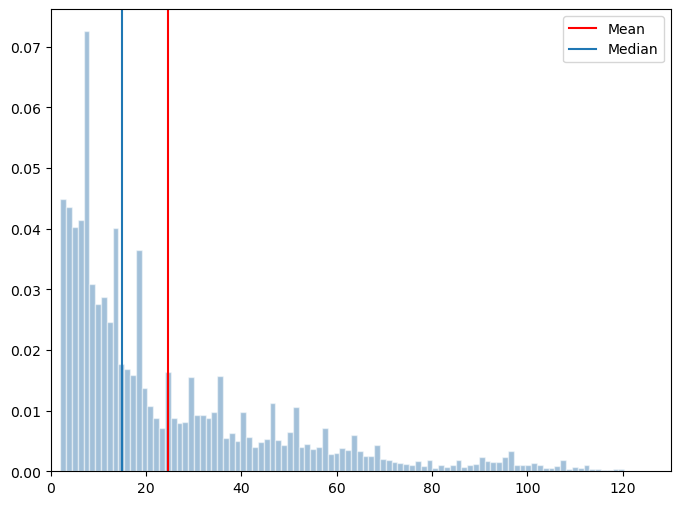

In [23]:
figure(figsize = (8, 6))

plt.hist(data_nmiss.plant_age, color = "steelblue", edgecolor = "white", bins = 100, density = true, alpha = 0.5)
plt.axvline(mean_age, label = "Mean", color = "red")
plt.axvline(median_age, label = "Median")

plt.legend()
plt.xlim(0, )
savefig("./plots/1.5.2.png")

We can also calculate and plot average plant age by country and technology Make sure all columns passed, other than the aggregation dimensions, are of type ```Float``` or ```Int```, otherwise the function execution will fail.

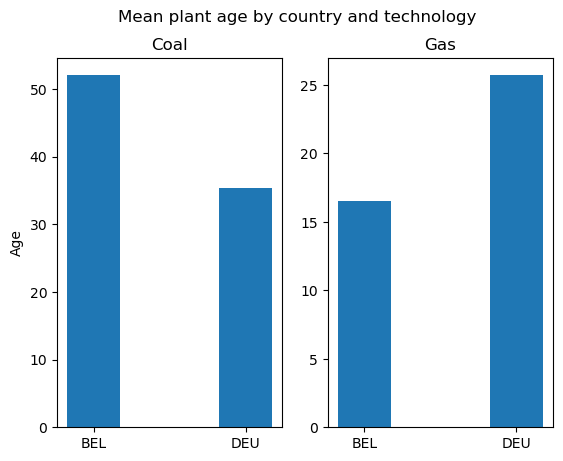

In [24]:
age = select(data_nmiss, [:country, :primary_fuel, :plant_age])
age_mean = combine(groupby(age, [:country , :primary_fuel]), :plant_age => mean)

coal_means = age_mean[occursin.(ctry_selec, age_mean.country) .& occursin.(r"Coal", age_mean.primary_fuel), :]
gas_means = age_mean[occursin.(ctry_selec, age_mean.country) .& occursin.(r"Gas", age_mean.primary_fuel), :]

width = 0.35 # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Mean plant age by country and technology")

ax1.bar(coal_means.country, coal_means.plant_age_mean, width, label = "Coal")
ax2.bar(gas_means.country, gas_means.plant_age_mean, width, label = "Gas")

ax1.set_ylabel("Age")

ax1.set_title("Coal")
ax2.set_title("Gas")
savefig("./plots/1.5.3.png")